# **DENSE NET**

1.  Please visit this link to access the state-of-art DenseNet code for reference - DenseNet - cifar10 notebook link
2.  You need to create a copy of this and "retrain" this model to achieve 90+ test accuracy. 
3.  You cannot use Dense Layers (also called fully connected layers), or DropOut.
4.  You MUST use Image Augmentation Techniques.
5.  You cannot use an already trained model as a beginning points, you have to initilize as your own
6.  You cannot run the program for more than 300 Epochs, and it should be clear from your log, that you have only used 300 Epochs
7.  You cannot use test images for training the model.
8.  You cannot change the general architecture of DenseNet (which means you must use Dense Block, Transition and Output blocks as mentioned in the code)
9.  You are free to change Convolution types (e.g. from 3x3 normal convolution to Depthwise Separable, etc)
10. You cannot have more than 1 Million parameters in total
11. You are free to move the code from Keras to Tensorflow, Pytorch, MXNET etc. 
12. You can use any optimization algorithm you need. 
13. You can checkpoint your model and retrain the model from that checkpoint so that no need of training the model from first if you lost at any epoch while training. You can directly load that model and Train from that epoch. 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

## 1. Load dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


## 2. Look at some random images 

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


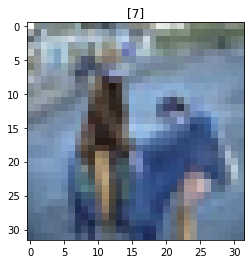

In [3]:
 random_num = np.random.randint(0, len(X_train))

plt.figure(figsize=(4,4))
plt.imshow(cv2.cvtColor(X_train[random_num], cv2.COLOR_BGR2RGB))
plt.title(y_train[random_num])
plt.show()

## 3. Normalise the data

In [4]:
X_train = X_train/255.0
X_test = X_test/255.0

## 4. Reshaping the data

In [5]:
img_height = 32
img_width = 32
channels = 3

In [6]:
import tensorflow.keras.backend as K

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], channels, img_height, img_width).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], channels, img_height, img_width).astype('float32')
    input_size = (channels, img_height, img_width)
    
else:
    X_train = X_train.reshape(X_train.shape[0], img_height, img_width, channels).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], img_height, img_width, channels).astype('float32')
    input_size = (img_height, img_width, channels)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(input_size)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
(32, 32, 3)


## 5. Convert y to 10 classes

In [8]:
#convert y to 10 categories
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


## 6. Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

## 7. Model- Architecture
1. Dense Block
2. Transition Block
3. Output layer
### Refer: https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow

![Dense Net Architecure](https://images.app.goo.gl/rbnE7H8rUTkP5PVv6)


### 7.1 Dense Block
- https://images.app.goo.gl/VDzxZGQUEL7kt5N58


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
num_classes = 10

In [11]:
#BN-->ReLU-->Conv2D-->Dropout-->concat(input, output)-->(put in loop)

def denseblock(input, num_filter, dropout_rate):
    global compression      # to keep the growth rate of number of filters
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)

        #concat the input(temp) and output(conv2d_3_3) , in resnet we add but here we concat 
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        #change the concat as input
        temp = concat
        
    return temp

### 7.2 Transition Block
- https://images.app.goo.gl/7ETwBQqHKwQwXPH26
- Conv 1x1 is the bottle neck layer here like in resnet


In [12]:
#BN-->relu-->conv2d(1x1)-->dropout-->avg_pool
def transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg


### 7.3 Output layer

In [13]:
#BN-->relu-->avgpool-->flat-->softmax
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

### 7.4 Full Architecture

In [14]:
# Hyperparameters
l = 12
num_filter = 12
compression = 0.5
dropout_rate = 0.2
num_classes = 10

In [15]:
input = layers.Input(shape=(input_size))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

#First dense and transition block
First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

#Second dense and transition block
Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

#Third dense and transition block
Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

#last dense and output block
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [16]:
model = tf.keras.models.Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## 8. Model Compile

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 9. Callbacks

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
patience = 50
base_path = '/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/'
checkpoint_file_name = base_path + 'CIFAR' + '_{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_loss', patience = patience)
reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(patience/3))

In [30]:
callbacks = [model_checkpoint, early_stop, reduce_LR]

## 10. Train the model

In [22]:
epochs = 300
batch_size = 128

In [31]:
#https://keras.io/api/preprocessing/image/#flow-method

history = model.fit(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test), verbose=1)

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/300
389/390 [============================>.] - ETA: 0s - loss: 1.3848 - accuracy: 0.4909
Epoch 00001: val_loss improved from inf to 1.78309, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_01-1.78.hdf5
390/390 [==============================] - 29s 73ms/step - loss: 1.3847 - accuracy: 0.4911 - val_loss: 1.7831 - val_accuracy: 0.4376
Epoch 2/300
389/390 [============================>.] - ETA: 0s - loss: 1.2734 - accuracy: 0.5363
Epoch 00002: val_loss improved from 1.78309 to 1.33771, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_02-1.34.hdf5
390/390 [==============================] - 28s 73ms/step - loss: 1.2729 - accuracy: 0.5363 - val_loss: 1.3377 - val_accuracy: 0.5480
Epoch 3/300
389/390 [============================>.] - ETA: 0s - loss: 1.1915 - accuracy: 0.5660
Epoch 00003: val_loss improved from 1.33771 to 1.29796, saving model to /home/ubuntu/Project/

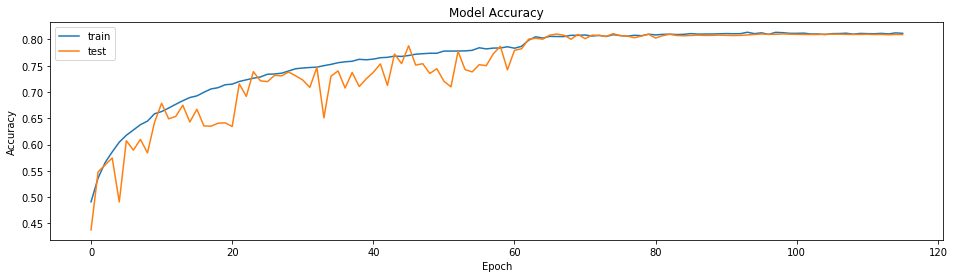

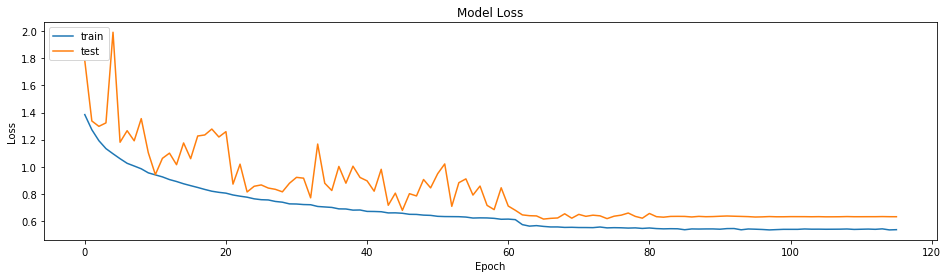

In [35]:
#history plot for accyracy
plt.figure(figsize=(16,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# history plot for accuracy
plt.figure(figsize=(16,4))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [38]:
model.metrics_names

['loss', 'accuracy']

In [40]:
best_model_1 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_66-0.61.hdf5')
scores = best_model_1.evaluate(X_test, y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 3s 348us/sample - loss: 0.6133 - accuracy: 0.8083
[0.6133434212684631, 0.8083]


## Summary:
- The model early stopped because the val loss is not reducing for 50 epochs. The best model is at epoch 66 and it gives the test accuracy of 0.8083. We can improve the accuracy further

## 11. By trying different learning rate

In [41]:
model_2 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_66-0.61.hdf5')
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 12)   324         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 12)   48          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 12)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [42]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
patience = 50
base_path = '/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/'
checkpoint_file_name = base_path + 'CIFAR_model2' + '_{epoch:02d}-{val_accuracy:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_accuracy', mode='max', patience = patience)
reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=int(patience/3))

In [44]:
callbacks = [model_checkpoint, early_stop, reduce_LR]

In [45]:
epochs = 300
batch_size = 128

In [46]:
#https://keras.io/api/preprocessing/image/#flow-method

history_2 = model_2.fit(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test), verbose=1)

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/300
389/390 [============================>.] - ETA: 0s - loss: 0.5581 - accuracy: 0.8033
Epoch 00001: val_accuracy improved from -inf to 0.80040, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model2_01-0.80.hdf5
390/390 [==============================] - 37s 95ms/step - loss: 0.5583 - accuracy: 0.8032 - val_loss: 0.6419 - val_accuracy: 0.8004
Epoch 2/300
389/390 [============================>.] - ETA: 0s - loss: 0.5614 - accuracy: 0.8053
Epoch 00002: val_accuracy improved from 0.80040 to 0.80220, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model2_02-0.80.hdf5
390/390 [==============================] - 29s 74ms/step - loss: 0.5614 - accuracy: 0.8053 - val_loss: 0.6375 - val_accuracy: 0.8022
Epoch 3/300
389/390 [============================>.] - ETA: 0s - loss: 0.5594 - accuracy: 0.8042
Epoch 00003: val_accuracy did not improve from 0.80220
390/390 [======

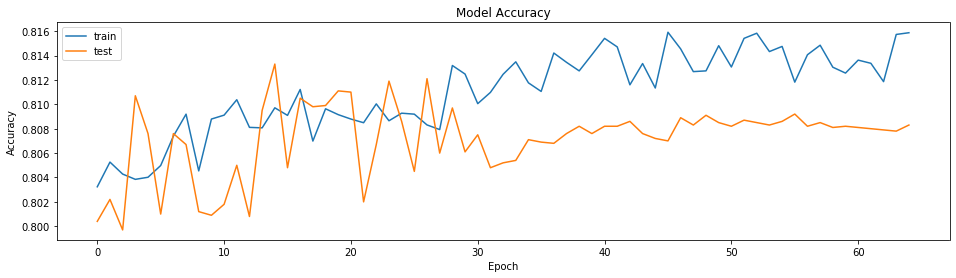

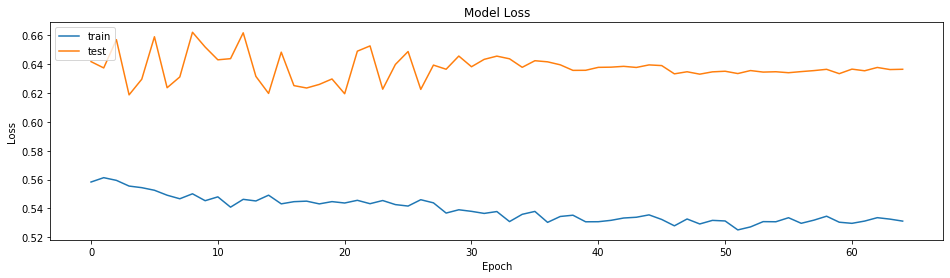

In [47]:
#history plot for accyracy
plt.figure(figsize=(16,4))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# history plot for accuracy
plt.figure(figsize=(16,4))
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### Summary:
- Even after changing the learning rate the model accuracy is not improved. Next we can try is different convolution and different num of filters

In [65]:
best_model_2 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model2_15-0.81.hdf5')
scores = best_model_2.evaluate(X_test, y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 3s 347us/sample - loss: 0.6198 - accuracy: 0.8133
[0.6198125976085663, 0.8133]


## 12. Model-3
- Seperable convolution
- num filters 32

In [52]:
#BN-->ReLU-->Conv2D-->Dropout-->concat(input, output)-->(put in loop)

def denseblock(input, num_filter, dropout_rate = 0.2):
    global compression      # to keep the growth rate of number of filters
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_5_5= layers.SeparableConv2D(int(num_filter*compression), (5,5), use_bias=False, padding='same')(relu)
        #Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_5_5 = layers.Dropout(dropout_rate)(Conv2D_5_5)

        #concat the input(temp) and output(conv2d_3_3) , in resnet we add but here we concat 
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_5_5])
        
        #change the concat as input
        temp = concat
        
    return temp

#BN-->relu-->conv2d(1x1)-->dropout-->avg_pool
def transition(input, num_filter, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    #Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    Conv2D_BottleNeck = layers.SeparableConvolution2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#BN-->relu-->avgpool-->flat-->softmax
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

# Hyperparameters
l = 12
num_filter = 32
compression = 0.5
dropout_rate = 0.2
num_classes = 10

input = layers.Input(shape=(input_size))
First_Conv2D = layers.Conv2D(num_filter, (5,5), use_bias=False ,padding='same')(input)

#First dense and transition block
First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

#Second dense and transition block
Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

#Third dense and transition block
Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

#last dense and output block
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [53]:
model_3 = tf.keras.models.Model(inputs=[input], outputs=[output])
model_3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 32, 32, 32)   2400        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 32, 32, 32)   128         conv2d_53[0][0]                  
__________________________________________________________________________________________________
activation_104 (Activation)     (None, 32, 32, 32)   0           batch_normalization_104[0][0]    
____________________________________________________________________________________________

In [54]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
patience = 50
base_path = '/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/'
checkpoint_file_name = base_path + 'CIFAR_model3' + '_{epoch:02d}-{val_accuracy:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_accuracy', mode='max', patience = patience)
reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=int(patience/3), verbose=1)

callbacks = [model_checkpoint, early_stop, reduce_LR]

epochs = 300
batch_size = 256

#https://keras.io/api/preprocessing/image/#flow-method

history_3 = model_3.fit(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test), verbose=1)

  ...
    to  
  ['...']
Train for 195 steps, validate on 10000 samples
Epoch 1/300
194/195 [============================>.] - ETA: 0s - loss: 1.6785 - accuracy: 0.3742
Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model3_01-0.10.hdf5
195/195 [==============================] - 41s 208ms/step - loss: 1.6764 - accuracy: 0.3745 - val_loss: 2.3508 - val_accuracy: 0.1000
Epoch 2/300
194/195 [============================>.] - ETA: 0s - loss: 1.3361 - accuracy: 0.5122
Epoch 00002: val_accuracy improved from 0.10000 to 0.13040, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model3_02-0.13.hdf5
195/195 [==============================] - 28s 145ms/step - loss: 1.3360 - accuracy: 0.5123 - val_loss: 2.6361 - val_accuracy: 0.1304
Epoch 3/300
194/195 [============================>.] - ETA: 0s - loss: 1.1621 - accuracy: 0.5800
Epoch 00003: val_accuracy improved from 0.13040 to 0.54500, saving m

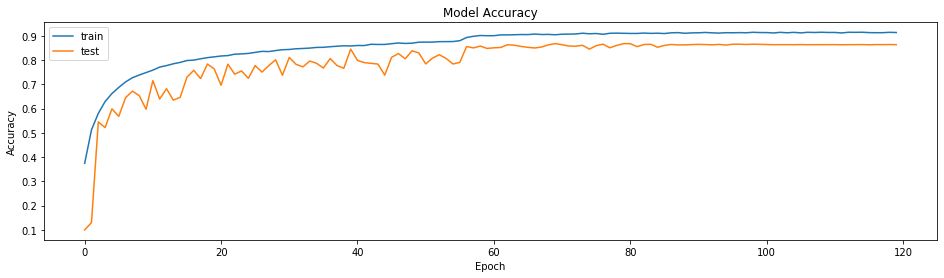

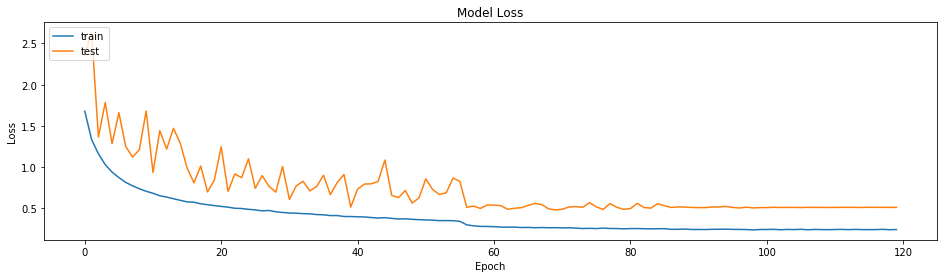

In [55]:
#history plot for accyracy
plt.figure(figsize=(16,4))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# history plot for accuracy
plt.figure(figsize=(16,4))
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [57]:
best_model_3 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model3_70-0.87.hdf5')
scores = best_model_3.evaluate(X_test, y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 4s 438us/sample - loss: 0.4829 - accuracy: 0.8681
[0.48287300192117694, 0.8681]


## Model -4

In [58]:
#BN-->ReLU-->Conv2D-->Dropout-->concat(input, output)-->(put in loop)

def denseblock(input, num_filter, dropout_rate = 0.2):
    global compression      # to keep the growth rate of number of filters
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_7_7= layers.SeparableConv2D(int(num_filter*compression), (7,7), use_bias=False, padding='same')(relu)
        #Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_7_7 = layers.Dropout(dropout_rate)(Conv2D_7_7)

        #concat the input(temp) and output(conv2d_3_3) , in resnet we add but here we concat 
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_7_7])
        
        #change the concat as input
        temp = concat
        
    return temp

#BN-->relu-->conv2d(1x1)-->dropout-->avg_pool
def transition(input, num_filter, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    #Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    Conv2D_BottleNeck = layers.SeparableConvolution2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#BN-->relu-->avgpool-->flat-->softmax
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

# Hyperparameters
l = 12
num_filter = 32
compression = 0.5
dropout_rate = 0.2
num_classes = 10

input = layers.Input(shape=(input_size))
First_Conv2D = layers.Conv2D(num_filter, (7,7), use_bias=False ,padding='same')(input)

#First dense and transition block
First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

#Second dense and transition block
Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

#Third dense and transition block
Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

#last dense and output block
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [59]:
model_4 = tf.keras.models.Model(inputs=[input], outputs=[output])
model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 32, 32, 32)   4704        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_156 (BatchN (None, 32, 32, 32)   128         conv2d_54[0][0]                  
__________________________________________________________________________________________________
activation_156 (Activation)     (None, 32, 32, 32)   0           batch_normalization_156[0][0]    
____________________________________________________________________________________________

In [60]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
patience = 50
base_path = '/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/'
checkpoint_file_name = base_path + 'CIFAR_model4' + '_{epoch:02d}-{val_accuracy:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_accuracy', mode='max', patience = patience)
reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=int(patience/3), verbose=1)

callbacks = [model_checkpoint, early_stop, reduce_LR]

epochs = 300
batch_size = 256

#https://keras.io/api/preprocessing/image/#flow-method

history_4 = model_4.fit(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test), verbose=1)

  ...
    to  
  ['...']
Train for 195 steps, validate on 10000 samples
Epoch 1/300
194/195 [============================>.] - ETA: 0s - loss: 1.7070 - accuracy: 0.3639
Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model4_01-0.10.hdf5
195/195 [==============================] - 70s 359ms/step - loss: 1.7059 - accuracy: 0.3643 - val_loss: 2.3413 - val_accuracy: 0.1000
Epoch 2/300
194/195 [============================>.] - ETA: 0s - loss: 1.3666 - accuracy: 0.5033
Epoch 00002: val_accuracy improved from 0.10000 to 0.19030, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model4_02-0.19.hdf5
195/195 [==============================] - 59s 301ms/step - loss: 1.3661 - accuracy: 0.5034 - val_loss: 2.2503 - val_accuracy: 0.1903
Epoch 3/300
194/195 [============================>.] - ETA: 0s - loss: 1.1866 - accuracy: 0.5744
Epoch 00003: val_accuracy improved from 0.19030 to 0.44100, saving m

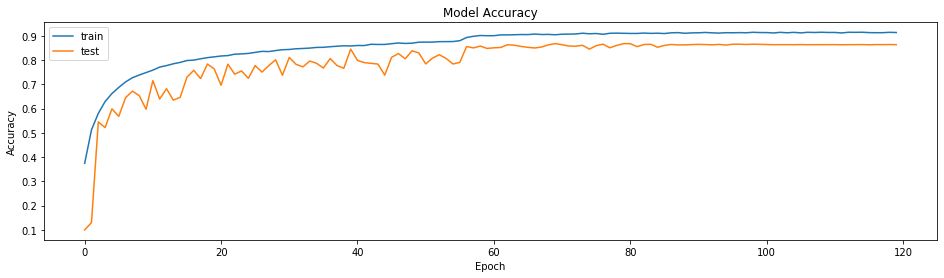

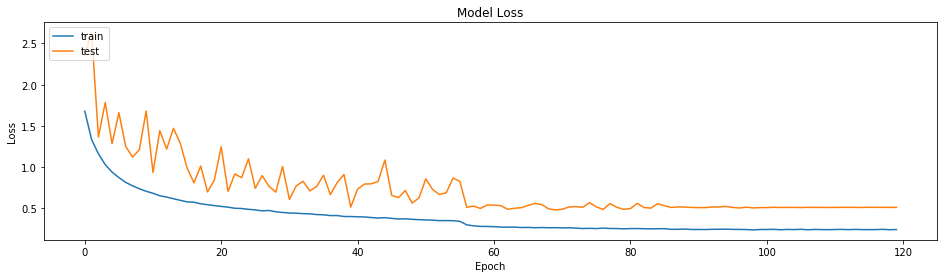

In [61]:
#history plot for accyracy
plt.figure(figsize=(16,4))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# history plot for accuracy
plt.figure(figsize=(16,4))
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [63]:
best_model_4 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model4_80-0.87.hdf5')
scores = best_model_4.evaluate(X_test, y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 4s 432us/sample - loss: 0.4873 - accuracy: 0.8716
[0.487310631595552, 0.8716]


## Model -5:
- dropout = 0.2
- compression = 0.3
- using conv instead of fully connected layers 

In [67]:
#BN-->ReLU-->Conv2D-->Dropout-->concat(input, output)-->(put in loop)
from tensorflow.keras import layers
from tensorflow.keras.models import Model
num_classes = 10

def denseblock(input, num_filter, dropout_rate):
    global compression      # to keep the growth rate of number of filters
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_7_7= layers.SeparableConv2D(int(num_filter*compression), (7,7), use_bias=False, padding='same')(relu)
        if dropout_rate>0:
            Conv2D_7_7 = layers.Dropout(dropout_rate)(Conv2D_7_7)

        #concat the input(temp) and output(conv2d_7_7) , in resnet we add but here we concat 
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_7_7])
        
        #change the concat as input
        temp = concat
        
    return temp

#BN-->relu-->conv2d(1x1)-->dropout-->avg_pool
def transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.SeparableConvolution2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#BN-->relu-->avgpool-->flat-->softmax
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    conv_op = layers.SeparableConvolution2D(num_classes, (2,2), padding='valid')(AvgPooling)
    flat = layers.Flatten()(conv_op)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

# Hyperparameters
l = 21
num_filter = 48
compression = 0.3
dropout_rate = 0.2
num_classes = 10

input = layers.Input(shape=(input_size))
First_Conv2D = layers.Conv2D(num_filter, (7,7), use_bias=False ,padding='same')(input)

#First dense and transition block
First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

#Second dense and transition block
Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

#Third dense and transition block
Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

#last dense and output block
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [68]:
model_5 = tf.keras.models.Model(inputs=[input], outputs=[output])
model_5.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 48)   7056        input_24[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2476 (Batch (None, 32, 32, 48)   192         conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation_2476 (Activation)    (None, 32, 32, 48)   0           batch_normalization_2476[0][0]   
___________________________________________________________________________________________

In [69]:
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
patience = 50
base_path = '/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/'
checkpoint_file_name = base_path + 'CIFAR_model5' + '_{epoch:02d}-{val_accuracy:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_accuracy', mode='max', patience = patience)
reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=int(patience/3), verbose=1)

callbacks = [model_checkpoint, early_stop, reduce_LR]

epochs = 300
batch_size = 128

#https://keras.io/api/preprocessing/image/#flow-method
history_5 = model_5.fit(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test), verbose=1)

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/300
389/390 [============================>.] - ETA: 0s - loss: 1.7504 - accuracy: 0.3315
Epoch 00001: val_accuracy improved from -inf to 0.22800, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model5_01-0.23.hdf5
390/390 [==============================] - 156s 401ms/step - loss: 1.7500 - accuracy: 0.3316 - val_loss: 2.3646 - val_accuracy: 0.2280
Epoch 2/300
389/390 [============================>.] - ETA: 0s - loss: 1.3674 - accuracy: 0.4987
Epoch 00002: val_accuracy improved from 0.22800 to 0.30130, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model5_02-0.30.hdf5
390/390 [==============================] - 136s 349ms/step - loss: 1.3671 - accuracy: 0.4989 - val_loss: 3.2475 - val_accuracy: 0.3013
Epoch 3/300
389/390 [============================>.] - ETA: 0s - loss: 1.1433 - accuracy: 0.5880
Epoch 00003: val_accuracy improved from 0.30130 to 0.41590, saving

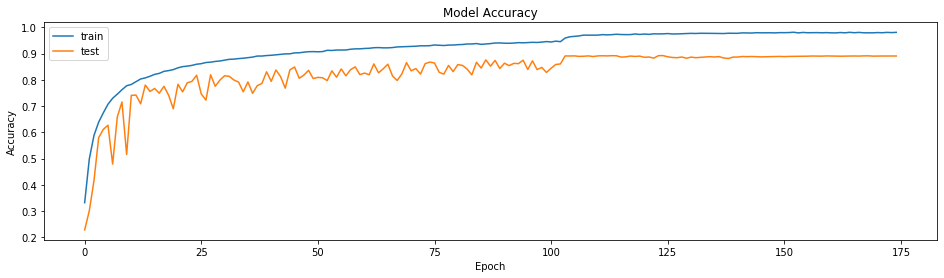

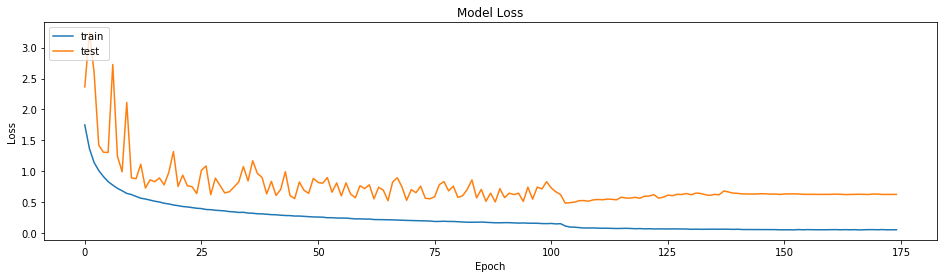

In [70]:
#history plot for accyracy
plt.figure(figsize=(16,4))
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# history plot for accuracy
plt.figure(figsize=(16,4))
plt.plot(history_5.history["loss"])
plt.plot(history_5.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [71]:
best_model_5 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model5_125-0.89.hdf5')
scores = best_model_5.evaluate(X_test, y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 9s 878us/sample - loss: 0.5825 - accuracy: 0.8921
[0.5824969663321972, 0.8921]


## 6. Model -6
- Model-5 without dropouts

In [11]:
#BN-->ReLU-->Conv2D-->Dropout-->concat(input, output)-->(put in loop)
from tensorflow.keras import layers
from tensorflow.keras.models import Model
num_classes = 10

def denseblock(input, num_filter, dropout_rate):
    global compression      # to keep the growth rate of number of filters
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_7_7= layers.SeparableConv2D(int(num_filter*compression), (7,7), use_bias=False, padding='same')(relu)
        if dropout_rate>0:
            Conv2D_7_7 = layers.Dropout(dropout_rate)(Conv2D_7_7)

        #concat the input(temp) and output(conv2d_7_7) , in resnet we add but here we concat 
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_7_7])
        
        #change the concat as input
        temp = concat
        
    return temp

#BN-->relu-->conv2d(1x1)-->dropout-->avg_pool
def transition(input, num_filter, dropout_rate):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.SeparableConvolution2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#BN-->relu-->avgpool-->flat-->softmax
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    conv_op = layers.SeparableConvolution2D(num_classes, (2,2), padding='valid')(AvgPooling)
    flat = layers.Flatten()(conv_op)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

# Hyperparameters
l = 21
num_filter = 48
compression = 0.3
dropout_rate = 0
num_classes = 10

input = layers.Input(shape=(input_size))
First_Conv2D = layers.Conv2D(num_filter, (7,7), use_bias=False ,padding='same')(input)

#First dense and transition block
First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

#Second dense and transition block
Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

#Third dense and transition block
Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

#last dense and output block
Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [12]:
model_6 = tf.keras.models.Model(inputs=[input], outputs=[output])
model_6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 48)   7056        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 48)   192         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 48)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
patience = 50
base_path = '/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/'
checkpoint_file_name = base_path + 'CIFAR_model6' + '_{epoch:02d}-{val_accuracy:.2f}.hdf5'

model_checkpoint = ModelCheckpoint(checkpoint_file_name, monitor='val_accuracy', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_accuracy', mode='max', patience = patience)
reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1, patience=int(patience/3), verbose=1)

callbacks = [model_checkpoint, early_stop, reduce_LR]

epochs = 300
batch_size = 128

#https://keras.io/api/preprocessing/image/#flow-method
history_6 = model_6.fit(data_generator.flow(X_train, y_train, batch_size),
                    steps_per_epoch = int(len(X_train)/batch_size),
                    epochs = epochs,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test), verbose=1)

  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/300
389/390 [============================>.] - ETA: 0s - loss: 1.6755 - accuracy: 0.3733
Epoch 00001: val_accuracy improved from -inf to 0.28830, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model6_01-0.29.hdf5
390/390 [==============================] - 161s 413ms/step - loss: 1.6753 - accuracy: 0.3734 - val_loss: 1.9707 - val_accuracy: 0.2883
Epoch 2/300
389/390 [============================>.] - ETA: 0s - loss: 1.2802 - accuracy: 0.5367
Epoch 00002: val_accuracy improved from 0.28830 to 0.50130, saving model to /home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model6_02-0.50.hdf5
390/390 [==============================] - 138s 354ms/step - loss: 1.2799 - accuracy: 0.5369 - val_loss: 1.4081 - val_accuracy: 0.5013
Epoch 3/300
389/390 [============================>.] - ETA: 0s - loss: 1.0749 - accuracy: 0.6182
Epoch 00003: val_accuracy improved from 0.50130 to 0.55070, saving

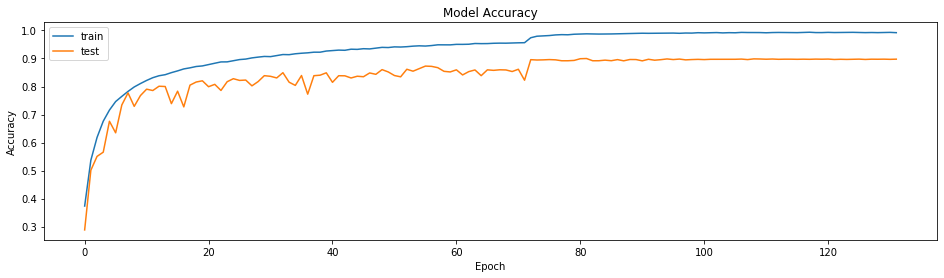

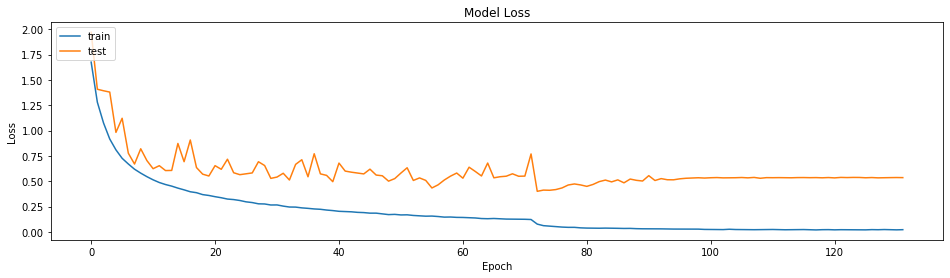

In [14]:
#history plot for accyracy
plt.figure(figsize=(16,4))
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# history plot for accuracy
plt.figure(figsize=(16,4))
plt.plot(history_6.history["loss"])
plt.plot(history_6.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [15]:
best_model_6 = tf.keras.models.load_model('/home/ubuntu/Project/my_data/CNN_CIFAR/checkpoint/CIFAR_model6_82-0.90.hdf5')
scores = best_model_6.evaluate(X_test, y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 9s 854us/sample - loss: 0.4682 - accuracy: 0.8999
[0.46815555404126646, 0.8999]


# Summary:

In [16]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Conv", 'final_layer', "kernel_size", 'dropout', 'No of parameters', "Test Accuracy"]
x.add_row(['model_1','Conv2D','dense', '3x3', '118,918', '0.2','80.83%'])
x.add_row(['model_2','Conv2D','dense', '3x3', '118,918', '0.2','81.33%'])
x.add_row(['model_3','SeparableConvolution2D', 'dense', '5x5', '0.2','258,282', '86.81%'])
x.add_row(['model_4','SeparableConvolution2D', 'dense', '7x7', '0.2','385,002', '87.16%'])
x.add_row(['model_5','SeparableConvolution2D', 'Conv2D', '7x7', '0.2','945,472', '89.21%'])
x.add_row(['model_5','SeparableConvolution2D', 'Conv2D', '7x7', '0','945,472', '89.999%'])

print(x)

+---------+------------------------+-------------+-------------+---------+------------------+---------------+
|  Model  |          Conv          | final_layer | kernel_size | dropout | No of parameters | Test Accuracy |
+---------+------------------------+-------------+-------------+---------+------------------+---------------+
| model_1 |         Conv2D         |    dense    |     3x3     | 118,918 |       0.2        |     80.83%    |
| model_2 |         Conv2D         |    dense    |     3x3     | 118,918 |       0.2        |     81.33%    |
| model_3 | SeparableConvolution2D |    dense    |     5x5     |   0.2   |     258,282      |     86.81%    |
| model_4 | SeparableConvolution2D |    dense    |     7x7     |   0.2   |     385,002      |     87.16%    |
| model_5 | SeparableConvolution2D |    Conv2D   |     7x7     |   0.2   |     945,472      |     89.21%    |
| model_5 | SeparableConvolution2D |    Conv2D   |     7x7     |    0    |     945,472      |    89.999%    |
+---------

# Note:
- After tried, final layer as Conv2D instead of flatten layer without dropout i have achieved test accuracy of 89.999%